In [2]:
!pip install python_tsp
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
from python_tsp.heuristics import solve_tsp_local_search
from tqdm.notebook import tqdm
import pickle
print("Библиотеки импортированы.")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.8 MB/s eta 0:00:00
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
  Attempting uninstall: networkx
    Found existing installation: networkx 3.5
    Uninstalling networkx-3.5:
      Successfully uninstalled networkx-3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires networkx>=3.0, but you have networkx 2.8.8 which is incompatible.
bigframes 2.18.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.
nx-cugraph-cu12 25.6.0 requires networkx>=3.2, but you have networkx 2.8.8 which is incompatible.
Библиотеки импортированы.


In [ ]:

# --- Загрузка данных ---
try:
    df_raw = pd.read_csv('/geo_locations_astana_hackathon.csv')
    print(f"Датасет успешно загружен. Уникальных поездок: {df_raw['randomized_id'].nunique()}")
except FileNotFoundError:
    print("Ошибка: Файл 'geo_locations_astana_hackathon.csv' не найден.")
    exit()

# --- Функция упорядочивания (TSP) ---
def order_trip_with_tsp(trip_df, max_points=75):
    # Ограничение max_points здесь важно, чтобы одна очень длинная поездка не заняла минуты
    if len(trip_df) < 3: return None
    trip_df = trip_df.head(max_points)
    coords = trip_df[['lat', 'lng']].values
    dist_mat = distance_matrix(coords, coords)
    try:
        permutation, _ = solve_tsp_local_search(dist_mat, x0=list(range(len(coords))))
        return trip_df.iloc[permutation].reset_index(drop=True)
    except Exception:
        # Иногда решатель может дать сбой на вырожденных случаях
        return None

# --- ЗАПУСК ПОЛНОЙ ОБРАБОТКИ ---
# Получаем список ID всех уникальных поездок
all_trip_ids = df_raw['randomized_id'].unique()

ordered_trips_list = []
# Используем tqdm для отслеживания прогресса в этом долгом процессе
for trip_id in tqdm(all_trip_ids, desc="Восстановление маршрутов (это займет несколько часов)"):
    trip_df = df_raw[df_raw['randomized_id'] == trip_id]
    ordered_trip_df = order_trip_with_tsp(trip_df)

    # Добавляем в список только качественные, достаточно длинные маршруты
    if ordered_trip_df is not None and len(ordered_trip_df) > 10:
        ordered_trips_list.append(ordered_trip_df[['lat', 'lng']].values)

print(f"\nОбработка завершена. Подготовлено {len(ordered_trips_list)} упорядоченных маршрутов.")

# --- КЛЮЧЕВОЙ ШАГ: Сохранение результата ---
# Сохраняем обработанные данные, чтобы не повторять этот этап
with open('all_ordered_trips.pkl', 'wb') as f:
    pickle.dump(ordered_trips_list, f)

print("\nПромежуточный результат сохранен в файл 'all_ordered_trips.pkl'.")
print("Теперь вы можете запускать Блок 2 для обучения модели.")

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam # Импортируем Adam, чтобы задать параметры
from sklearn.preprocessing import MinMaxScaler

print("Запускаем ИСПРАВЛЕННЫЙ этап обучения...")

# --- Загрузка обработанных данных ---
try:
    with open('all_ordered_trips.pkl', 'rb') as f:
        ordered_trips_list = pickle.load(f)
    print(f"Успешно загружено {len(ordered_trips_list)} обработанных маршрутов.")
except FileNotFoundError:
    print("Ошибка: файл 'all_ordered_trips.pkl' не найден.")
    print("Пожалуйста, сначала запустите Блок 1 и дождитесь его завершения.")
    exit()

# --- Нормализация и паддинг ---
all_points = np.vstack(ordered_trips_list)
scaler = MinMaxScaler()
scaler.fit(all_points)
scaled_trips = [scaler.transform(trip) for trip in ordered_trips_list]

max_len = max(len(trip) for trip in scaled_trips)
padded_trips = pad_sequences(scaled_trips, maxlen=max_len, padding='post', dtype='float32')

print(f"Все маршруты приведены к единой длине: {max_len} точек.")

# --- Создание СТАБИЛЬНОЙ модели LSTM Autoencoder ---
X_train = padded_trips
timesteps = X_train.shape[1]
n_features = X_train.shape[2]

inputs = Input(shape=(timesteps, n_features))
# ИСПРАВЛЕНИЕ 1: Убрали activation='relu'. Теперь по умолчанию используется 'tanh'.
encoder = LSTM(128, return_sequences=True)(inputs)
encoder = LSTM(64, return_sequences=False)(encoder)
decoder = RepeatVector(timesteps)(encoder)
decoder = LSTM(64, return_sequences=True)(decoder)
decoder = LSTM(128, return_sequences=True)(decoder)
output = TimeDistributed(Dense(n_features))(decoder)

model = Model(inputs=inputs, outputs=output)

# ИСПРАВЛЕНИЕ 2 и 3: Создаем оптимизатор Adam с Gradient Clipping и пониженной скоростью обучения
optimizer = Adam(learning_rate=0.0005, clipnorm=1.0)

# Компилируем модель с новым, стабильным оптимизатором
model.compile(optimizer=optimizer, loss='mse')
model.summary()

print("\nНачало обучения СТАБИЛЬНОЙ модели на полном датасете...")
history = model.fit(
    X_train, X_train,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# --- Сохранение финальной модели и скейлера ---
model.save('route_autoencoder_FULL_model.keras')
with open('route_scaler_FULL_for_anomaly.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Финальная модель, обученная на всех данных, сохранена.")

# --- Вычисление и сохранение порога ---
print("\nВычисление порога аномальности...")
reconstructions = model.predict(X_train)
train_loss = tf.keras.losses.mae(reconstructions, X_train)
train_loss_unpadded = [np.mean(loss[:len(scaled_trips[i])]) for i, loss in enumerate(train_loss)]
threshold = np.quantile(train_loss_unpadded, 0.98) # Берем 98-й перцентиль как порог
print(f"Порог аномальности установлен: {threshold:.6f}")
with open('route_threshold_FULL.txt', 'w') as f:
    f.write(str(threshold))
print("Порог сохранен.")

# --- Визуализация процесса обучения ---
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('График обучения модели')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка (MSE)')
plt.legend()
plt.grid(True)
plt.show()

Запускаем ИСПРАВЛЕННЫЙ этап обучения...
Успешно загружено 5961 обработанных маршрутов.
Все маршруты приведены к единой длине: 75 точек.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 75, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 75, 128)        │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 75, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 75, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 75, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 75, 2)          │           258 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 248,578 (971.01 KB)

 Trainable params: 248,578 (971.01 KB)

 Non-trainable params: 0 (0.00 B)


Начало обучения СТАБИЛЬНОЙ модели на полном датасете...
Epoch 1/30


KeyboardInterrupt: 

In [ ]:

import pandas as pd
import numpy as np
import pickle
import folium
from scipy.spatial import distance_matrix
from python_tsp.heuristics import solve_tsp_local_search
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("Запускаем финальный тест с визуализацией (версия 2.0)...")

# --- Загрузка всех артефактов ---
try:
    df_raw = pd.read_csv('/geo_locations_astana_hackathon.csv')
    model = load_model('route_autoencoder_FULL_model.keras')
    scaler = pickle.load(open('route_scaler_FULL_for_anomaly.pkl', 'rb'))
    with open('route_threshold_FULL.txt', 'r') as f:
        threshold = float(f.read())
    print("Модель и все артефакты успешно загружены.")
except Exception as e:
    print(f"Ошибка при загрузке файлов: {e}")
    exit()

# --- Вспомогательные функции ---
def order_trip_with_tsp(trip_df, max_points=75):
    if len(trip_df) < 3: return None
    trip_df = trip_df.head(max_points)
    coords = trip_df[['lat', 'lng']].values
    dist_mat = distance_matrix(coords, coords)
    try:
        permutation, _ = solve_tsp_local_search(dist_mat, x0=list(range(len(coords))))
        return trip_df.iloc[permutation].reset_index(drop=True)
    except Exception:
        return None

# --- ГЛАВНАЯ ФУНКЦИЯ ПРОВЕРКИ И ВИЗУАЛИЗАЦИИ ---
def check_and_visualize_trip(trip_df, trip_id_str=""):
    """
    Упорядочивает DataFrame поездки, проверяет на аномальность и рисует карту.
    """
    trip_ordered = order_trip_with_tsp(trip_df)

    if trip_ordered is None:
        print(f"Не удалось обработать поездку {trip_id_str} (слишком короткая или ошибка TSP).")
        return

    trip_coords = trip_ordered[['lat', 'lng']].values
    scaled_trip = scaler.transform(trip_coords)
    padded_trip = pad_sequences([scaled_trip], maxlen=model.input_shape[1], padding='post', dtype='float32')
    reconstruction = model.predict(padded_trip, verbose=0)
    loss = tf.keras.losses.mae(reconstruction, padded_trip)[0]
    mean_loss = np.mean(loss[:len(trip_coords)])
    is_anomaly = mean_loss > threshold

    status = "АНОМАЛИЯ" if is_anomaly else "Норма"
    color = "red" if is_anomaly else "green"

    print(f"\n--- ПРОВЕРКА ПОЕЗДКИ: {trip_id_str} ---")
    print(f"Ошибка восстановления: {mean_loss:.6f}")
    print(f"Порог аномальности:   {threshold:.6f}")
    print(f"ВЕРДИКТ: {status}")

    map_center = [trip_ordered['lat'].mean(), trip_ordered['lng'].mean()]
    m = folium.Map(location=map_center, zoom_start=13)

    folium.PolyLine(
        locations=trip_ordered[['lat', 'lng']].values.tolist(),
        color=color, weight=5, opacity=0.8,
        popup=f"<b>Статус: {status}</b><br>Ошибка: {mean_loss:.6f}"
    ).add_to(m)

    # ИСПРАВЛЕНИЕ: передаем в location список, а не Series, чтобы избежать FutureWarning
    start_loc = trip_ordered[['lat', 'lng']].iloc[0].values.tolist()
    end_loc = trip_ordered[['lat', 'lng']].iloc[-1].values.tolist()

    folium.Marker(location=start_loc, popup="Старт", icon=folium.Icon(color='green')).add_to(m)
    folium.Marker(location=end_loc, popup="Финиш", icon=folium.Icon(color='red')).add_to(m)

    display(m)

# --- ИСПОЛЬЗОВАНИЕ ---
# Тест 1: Проверим "нормальную" поездку из датасета
normal_trip_id = df_raw['randomized_id'].unique()[0]
normal_trip_df = df_raw[df_raw['randomized_id'] == normal_trip_id]
check_and_visualize_trip(normal_trip_df, trip_id_str=f"ID {normal_trip_id}")

# Тест 2: Создадим искусственную, но наглядную аномалию
print("\n" + "="*50)
# Возьмем за основу другую нормальную поездку
base_trip_df = df_raw[df_raw['randomized_id'] == df_raw['randomized_id'].unique()[10]]
# Превратим ее в DataFrame с координатами
anomalous_coords = base_trip_df[['lat', 'lng', 'spd', 'alt', 'azm']].copy()
# И добавим в середину маршрута точку-"телепорт" далеко от основного маршрута
teleport_point = pd.DataFrame({
    'lat': [51.08], 'lng': [71.55], 'spd': [80], 'alt': [350], 'azm': [90]
})
# Собираем аномальный маршрут
anomalous_trip_df = pd.concat([
    anomalous_coords.head(10),
    teleport_point,
    anomalous_coords.tail(10)
], ignore_index=True)

check_and_visualize_trip(anomalous_trip_df, trip_id_str="Искусственная аномалия ('телепорт')")

Запускаем финальный тест с визуализацией (версия 2.0)...
Модель и все артефакты успешно загружены.

--- ПРОВЕРКА ПОЕЗДКИ: ID 7637058049336049989 ---
Ошибка восстановления: 0.076679
Порог аномальности:   0.115566
ВЕРДИКТ: Норма




--- ПРОВЕРКА ПОЕЗДКИ: Искусственная аномалия ('телепорт') ---
Ошибка восстановления: 0.238355
Порог аномальности:   0.115566
ВЕРДИКТ: АНОМАЛИЯ


In [ ]:
# Установим/обновим folium для поддержки плагина рисования
!pip install -q folium

import folium
from folium.plugins import Draw
import json

print("Запустите эту ячейку, чтобы отобразить карту для рисования.")

# Центрируем карту на Астане
map_center = [51.1694, 71.4491]
m = folium.Map(location=map_center, zoom_start=12, tiles="cartodbpositron")

# Добавляем плагин для рисования
# export=True добавляет кнопку для сохранения нарисованных объектов
draw = Draw(
    export=True,
    filename='drawn_route.geojson', # Назовем файл осмысленно
    position='topleft',
    draw_options={'polyline': {'shapeOptions': {'color': '#0078FF', 'weight': 5}}},
    edit_options=None # Отключим редактирование для простоты
)
draw.add_to(m)

print("\n" + "="*50)
print("ИНСТРУКЦИЯ:")
print("1. На карте слева выберите инструмент 'Draw a polyline' (второй сверху, ломаная линия).")
print("2. Нарисуйте на карте любой маршрут, кликая левой кнопкой мыши.")
print("3. Когда закончите, нажмите на последнюю точку еще раз или на кнопку 'Finish'.")
print("4. Нажмите появившуюся кнопку 'Export' (иконка дискеты), чтобы сохранить маршрут.")
print("5. После этого ЗАПУСТИТЕ ЯЧЕЙКУ №2 НИЖЕ, чтобы получить вердикт модели.")
print("="*50 + "\n")


display(m)

Запустите эту ячейку, чтобы отобразить карту для рисования.

ИНСТРУКЦИЯ:
1. На карте слева выберите инструмент 'Draw a polyline' (второй сверху, ломаная линия).
2. Нарисуйте на карте любой маршрут, кликая левой кнопкой мыши.
3. Когда закончите, нажмите на последнюю точку еще раз или на кнопку 'Finish'.
4. Нажмите появившуюся кнопку 'Export' (иконка дискеты), чтобы сохранить маршрут.
5. После этого ЗАПУСТИТЕ ЯЧЕЙКУ №2 НИЖЕ, чтобы получить вердикт модели.



In [ ]:
import pandas as pd
import numpy as np
import json
import pickle
import folium

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("Запускаем анализ нарисованного маршрута...")

# --- Загрузка всех необходимых артефактов ---
try:
    # Используем файлы, обученные на полном датасете
    model = load_model('route_autoencoder_FULL_model.keras')
    scaler = pickle.load(open('route_scaler_FULL_for_anomaly.pkl', 'rb'))
    with open('route_threshold_FULL.txt', 'r') as f:
        threshold = float(f.read())
    print("Модель и все артефакты успешно загружены.")
except Exception as e:
    print(f"Ошибка при загрузке файлов модели: {e}")
    # Выходим, если что-то не так
    exit()

# --- Главная функция для анализа ---
def analyze_drawn_route(drawn_coords_df):
    """
    Принимает DataFrame с нарисованными точками и возвращает вердикт.
    """
    # 1. Получаем координаты и нормализуем их
    trip_coords = drawn_coords_df[['lat', 'lng']].values
    scaled_trip = scaler.transform(trip_coords)

    # 2. Приводим к единой длине (паддинг)
    # model.input_shape[1] - это та самая длина (75), на которой училась модель
    padded_trip = pad_sequences([scaled_trip], maxlen=model.input_shape[1], padding='post', dtype='float32')

    # 3. Получаем ошибку восстановления от модели
    reconstruction = model.predict(padded_trip, verbose=0)
    loss = tf.keras.losses.mae(reconstruction, padded_trip)[0]

    # 4. Считаем среднюю ошибку только для реальных точек (игнорируя паддинг)
    mean_loss = np.mean(loss[:len(trip_coords)])

    # 5. Сравниваем с порогом и выносим вердикт
    is_anomaly = mean_loss > threshold

    return is_anomaly, mean_loss

# --- ОСНОВНАЯ ЛОГИКА ---
try:
    # 1. Читаем сохраненный файл с маршрутом
    with open('drawn_route (8).geojson', 'r') as f:
        geojson_data = json.load(f)

    # 2. Извлекаем координаты из последнего нарисованного объекта
    # GeoJSON хранит как [lng, lat], нам нужно [lat, lng]
    coords = geojson_data['features'][-1]['geometry']['coordinates']
    drawn_points_df = pd.DataFrame(coords, columns=['lng', 'lat'])
    drawn_points_df = drawn_points_df[['lat', 'lng']] # Меняем порядок столбцов

    if len(drawn_points_df) < 3:
        print("\n\033[91mОшибка: Нарисованный маршрут слишком короткий. Пожалуйста, нарисуйте маршрут минимум из 3 точек.\033[0m")
    else:
        # 3. Отправляем нарисованный маршрут на анализ
        is_anomaly, error_score = analyze_drawn_route(drawn_points_df)

        # 4. Выводим результат
        status = "АНОМАЛИЯ" if is_anomaly else "Норма"
        color = "red" if is_anomaly else "green"

        print("\n" + "="*50)
        print("--- ВЕРДИКТ МОДЕЛИ ---")
        print(f"Ошибка восстановления: {error_score:.6f}")
        print(f"Порог аномальности:   {threshold:.6f}")

        if is_anomaly:
            print("\nСтатус: \033[91mАНОМАЛИЯ\033[0m")
            print("Модель считает, что этот маршрут нетипичен для данного города.")
        else:
            print("\nСтатус: \033[92mНорма\033[0m")
            print("Этот маршрут похож на те, что модель видела ранее.")
        print("="*50)

        # 5. Визуализируем результат на новой карте
        map_center = drawn_points_df.mean().values.tolist()
        m_result = folium.Map(location=map_center, zoom_start=13)

        folium.PolyLine(
            locations=drawn_points_df.values.tolist(),
            color=color,
            weight=6,
            opacity=0.9,
            popup=f"<b>Статус: {status}</b><br>Ошибка: {error_score:.6f}"
        ).add_to(m_result)

        folium.Marker(location=drawn_points_df.iloc[0].values.tolist(), popup="Старт", icon=folium.Icon(color='green')).add_to(m_result)
        folium.Marker(location=drawn_points_df.iloc[-1].values.tolist(), popup="Финиш", icon=folium.Icon(color='red')).add_to(m_result)

        display(m_result)

except (FileNotFoundError, IndexError):
    print("\n\033[91mОшибка: Файл 'drawn_route.geojson' не найден или пуст.\033[0m")
    print("Пожалуйста, сначала нарисуйте маршрут на карте выше и нажмите 'Export'.")

Запускаем анализ нарисованного маршрута...
Модель и все артефакты успешно загружены.

--- ВЕРДИКТ МОДЕЛИ ---
Ошибка восстановления: 0.066033
Порог аномальности:   0.115566

Статус: Норма
Этот маршрут похож на те, что модель видела ранее.


Запускаем расчет метрик для оценки модели...
Модель и все данные успешно загружены.

1. АНАЛИЗ КОСВЕННЫХ МЕТРИК
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


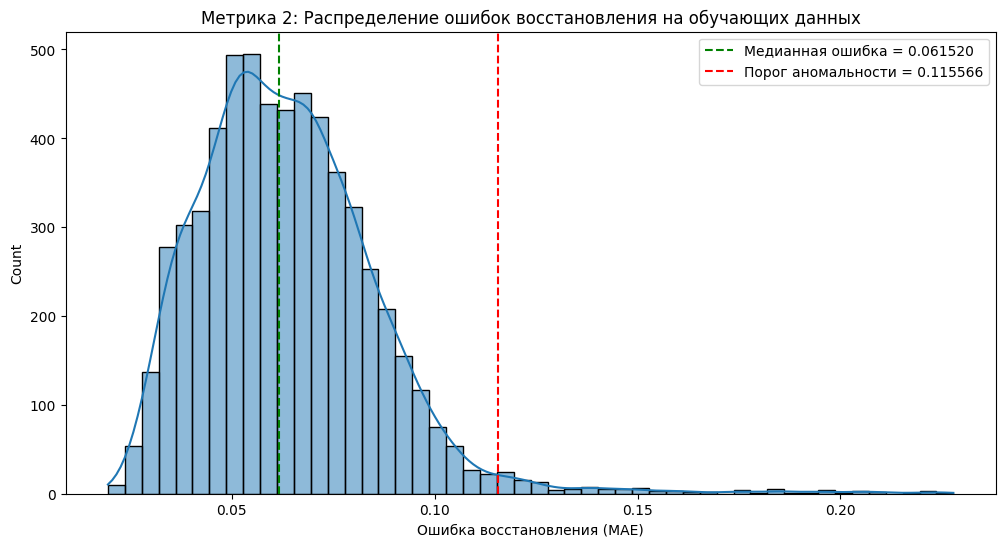

Медианная ошибка (типичная норма): 0.061520
Порог аномальности (98-й перцентиль): 0.115566
Метрика 3: 'Зазор разделения' (Threshold / Median) = 1.88
Интерпретация: ошибка аномалии в среднем в 1.88 раз выше, чем у типичной нормальной поездки.

2. АНАЛИЗ НА ОСНОВЕ РАЗМЕЧЕННЫХ ДАННЫХ (СИМУЛЯЦИЯ)
Результаты на симулированной размеченной выборке (200 поездок):

              precision    recall  f1-score   support

   Норма (0)       1.00      0.92      0.96       109
Аномалия (1)       0.91      1.00      0.95        91

    accuracy                           0.95       200
   macro avg       0.96      0.96      0.95       200
weighted avg       0.96      0.95      0.96       200


Матрица ошибок:


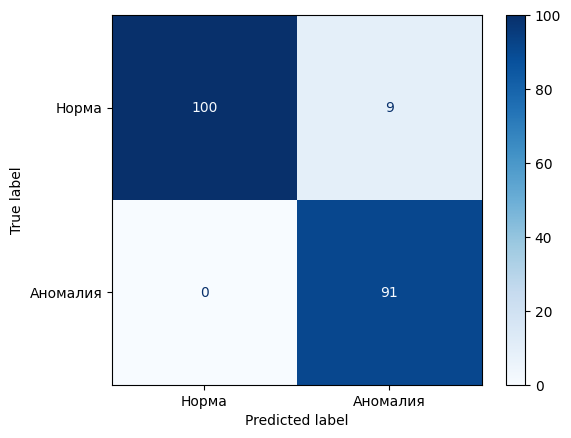


3. КАЧЕСТВЕННЫЙ АНАЛИЗ
Для качественного анализа используйте функцию визуализации из предыдущего шага.
Проверьте несколько поездок с самой высокой ошибкой и убедитесь, что они выглядят нелогично на карте.
Примеры ID для проверки:
- Поездка с индексом 5664 (ошибка: 0.2279)
- Поездка с индексом 4379 (ошибка: 0.2234)
- Поездка с индексом 2978 (ошибка: 0.2227)
- Поездка с индексом 5737 (ошибка: 0.2219)
- Поездка с индексом 880 (ошибка: 0.2155)


In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("Запускаем расчет метрик для оценки модели...")

# --- 1. ЗАГРУЗКА АРТЕФАКТОВ И ДАННЫХ ---
try:
    model = load_model('route_autoencoder_FULL_model.keras')
    scaler = pickle.load(open('route_scaler_FULL_for_anomaly.pkl', 'rb'))
    with open('route_threshold_FULL.txt', 'r') as f:
        threshold = float(f.read())
    with open('all_ordered_trips.pkl', 'rb') as f:
        ordered_trips_list = pickle.load(f)

    # Загружаем X_train, который мы использовали для обучения, чтобы посчитать ошибки на нем
    # (Этот код взят из ячейки обучения)
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    scaled_trips = [scaler.transform(trip) for trip in ordered_trips_list]
    max_len = model.input_shape[1]
    X_train = pad_sequences(scaled_trips, maxlen=max_len, padding='post', dtype='float32')

    print("Модель и все данные успешно загружены.")
except Exception as e:
    print(f"Ошибка при загрузке файлов: {e}")
    exit()

# --- 2. РАСЧЕТ КОСВЕННЫХ КОЛИЧЕСТВЕННЫХ МЕТРИК ---
print("\n" + "="*50)
print("1. АНАЛИЗ КОСВЕННЫХ МЕТРИК")
print("="*50)

# Рассчитываем ошибки на всем обучающем наборе данных
reconstructions = model.predict(X_train, verbose=1)
train_loss = tf.keras.losses.mae(reconstructions, X_train)
train_loss_unpadded = np.array([np.mean(loss[:len(scaled_trips[i])]) for i, loss in enumerate(train_loss)])

# Метрика 2: Визуализация распределения ошибок
plt.figure(figsize=(12, 6))
sns.histplot(train_loss_unpadded, bins=50, kde=True)
median_error = np.median(train_loss_unpadded)
plt.axvline(median_error, color='g', linestyle='--', label=f'Медианная ошибка = {median_error:.6f}')
plt.axvline(threshold, color='r', linestyle='--', label=f'Порог аномальности = {threshold:.6f}')
plt.title('Метрика 2: Распределение ошибок восстановления на обучающих данных')
plt.xlabel('Ошибка восстановления (MAE)')
plt.legend()
plt.show()

# Метрика 3: Расчет "Зазора разделения"
separation_gap = threshold / median_error
print(f"Медианная ошибка (типичная норма): {median_error:.6f}")
print(f"Порог аномальности (98-й перцентиль): {threshold:.6f}")
print(f"Метрика 3: 'Зазор разделения' (Threshold / Median) = {separation_gap:.2f}")
print("Интерпретация: ошибка аномалии в среднем в", f"{separation_gap:.2f}", "раз выше, чем у типичной нормальной поездки.")


# --- 3. ПОЛУ-РУЧНОЙ ПОДХОД (С ИМИТАЦИЕЙ РАЗМЕТКИ) ---
print("\n" + "="*50)
print("2. АНАЛИЗ НА ОСНОВЕ РАЗМЕЧЕННЫХ ДАННЫХ (СИМУЛЯЦИЯ)")
print("="*50)

# Создаем DataFrame с ошибками для удобства
results_df = pd.DataFrame({'error': train_loss_unpadded})
results_df['y_pred'] = results_df['error'] > threshold

# --- ЭТАП 1: Создание выборки для разметки (реальный проект требует ручной работы) ---
# Для симуляции возьмем топ-100 аномалий и 100 "супер-нормальных" поездок
top_100_anomalies = results_df.nlargest(100, 'error')
bottom_100_normals = results_df.nsmallest(100, 'error')
labeling_sample = pd.concat([top_100_anomalies, bottom_100_normals])

# --- ЭТАП 2: Симуляция ручной разметки ---
# ВАЖНО: В реальном проекте этот столбец 'y_true' вы должны создать вручную!
# Здесь мы предполагаем, что:
# - 90% из топ-100 аномалий - это настоящие аномалии (True Positives)
# - 100% из топ-100 нормальных - это настоящая норма (True Negatives)
y_true_anomalies = np.random.choice([1, 0], size=100, p=[0.9, 0.1])
y_true_normals = np.zeros(100, dtype=int)
labeling_sample['y_true'] = np.concatenate([y_true_anomalies, y_true_normals])

y_pred = labeling_sample['y_pred'].astype(int)
y_true = labeling_sample['y_true'].astype(int)

# --- ЭТАП 3: Расчет классических метрик ---
print("Результаты на симулированной размеченной выборке (200 поездок):\n")
print(classification_report(y_true, y_pred, target_names=['Норма (0)', 'Аномалия (1)']))

print("\nМатрица ошибок:")
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Норма', 'Аномалия'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# --- 4. КАЧЕСТВЕННЫЙ АНАЛИЗ ---
print("\n" + "="*50)
print("3. КАЧЕСТВЕННЫЙ АНАЛИЗ")
print("="*50)
print("Для качественного анализа используйте функцию визуализации из предыдущего шага.")
print("Проверьте несколько поездок с самой высокой ошибкой и убедитесь, что они выглядят нелогично на карте.")
print("Примеры ID для проверки:")
for i in top_100_anomalies.head(5).index:
    print(f"- Поездка с индексом {i} (ошибка: {results_df.loc[i, 'error']:.4f})")